In [3]:
# Calling third-party libraries
import os
import io
import base64
import datetime     
import calendar      
import time
import re 
import folium
import webbrowser

#Data processing
import pandas as pd
from dateutil import parser
import numpy as np
import math
from haversine import haversine 

#Visualization
from matplotlib.pyplot import *
from matplotlib import animation 
import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns
import matplotlib.animation as animation
import urllib                                
import scipy               
from PIL import Image
from scipy import ndimage
from imageio import imread
import chart_studio.plotly as py
from matplotlib import cm
from bokeh.palettes import Spectral4
from bokeh.plotting import figure, output_notebook, show
from IPython.display import HTML
from matplotlib.animation import FuncAnimation, FFMpegWriter

#MachineLearning
from sklearn.cluster import KMeans
from sklearn.neighbors import KNeighborsClassifier
import sklearn
from sklearn.pipeline import Pipeline
import xgboost as xgb
from sklearn.metrics import mean_absolute_error, mean_squared_error
import warnings
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.cluster import MiniBatchKMeans

warnings.filterwarnings("ignore")
output_notebook()

Loading BokehJS ...

In [4]:
#Retrieve data
df=pd.read_csv('train.csv')
df.head()
df.info

<bound method DataFrame.info of                 id  vendor_id      pickup_datetime     dropoff_datetime  \
0        id2875421          2  2016-03-14 17:24:55  2016-03-14 17:32:30   
1        id2377394          1  2016-06-12 00:43:35  2016-06-12 00:54:38   
2        id3858529          2  2016-01-19 11:35:24  2016-01-19 12:10:48   
3        id3504673          2  2016-04-06 19:32:31  2016-04-06 19:39:40   
4        id2181028          2  2016-03-26 13:30:55  2016-03-26 13:38:10   
...            ...        ...                  ...                  ...   
1458639  id2376096          2  2016-04-08 13:31:04  2016-04-08 13:44:02   
1458640  id1049543          1  2016-01-10 07:35:15  2016-01-10 07:46:10   
1458641  id2304944          2  2016-04-22 06:57:41  2016-04-22 07:10:25   
1458642  id2714485          1  2016-01-05 15:56:26  2016-01-05 16:02:39   
1458643  id1209952          1  2016-04-05 14:44:25  2016-04-05 14:47:43   

         passenger_count  pickup_longitude  pickup_latitude  \
0   

<bound method DataFrame.info of                 id  vendor_id      pickup_datetime     dropoff_datetime  \
0        id2875421          2  2016-03-14 17:24:55  2016-03-14 17:32:30   
1        id2377394          1  2016-06-12 00:43:35  2016-06-12 00:54:38   
2        id3858529          2  2016-01-19 11:35:24  2016-01-19 12:10:48   
3        id3504673          2  2016-04-06 19:32:31  2016-04-06 19:39:40   
4        id2181028          2  2016-03-26 13:30:55  2016-03-26 13:38:10   
...            ...        ...                  ...                  ...   
1458639  id2376096          2  2016-04-08 13:31:04  2016-04-08 13:44:02   
1458640  id1049543          1  2016-01-10 07:35:15  2016-01-10 07:46:10   
1458641  id2304944          2  2016-04-22 06:57:41  2016-04-22 07:10:25   
1458642  id2714485          1  2016-01-05 15:56:26  2016-01-05 16:02:39   
1458643  id1209952          1  2016-04-05 14:44:25  2016-04-05 14:47:43   

         passenger_count  pickup_longitude  pickup_latitude  \
0   

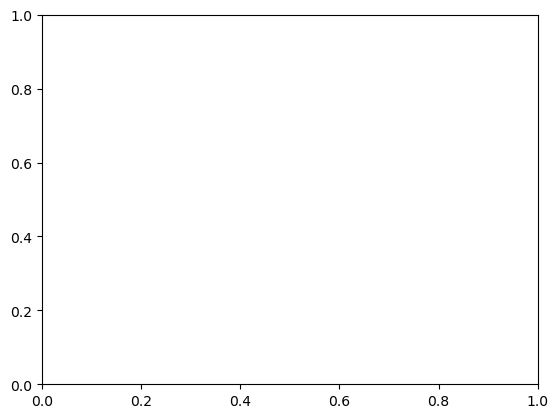

In [7]:
#Data processing
(df.pickup_longitude > xlim()[0]) & (df.pickup_longitude < xlim()[1])
xlim = [-74.03, -73.77]
ylim = [40.63, 40.85]
df = df[(df.pickup_longitude> xlim[0]) & (df.pickup_longitude < xlim[1])]
df = df[(df.dropoff_longitude> xlim[0]) & (df.dropoff_longitude < xlim[1])]
df = df[(df.pickup_latitude> ylim[0]) & (df.pickup_latitude < ylim[1])]
df = df[(df.dropoff_latitude> ylim[0]) & (df.dropoff_latitude < ylim[1])]
df.info

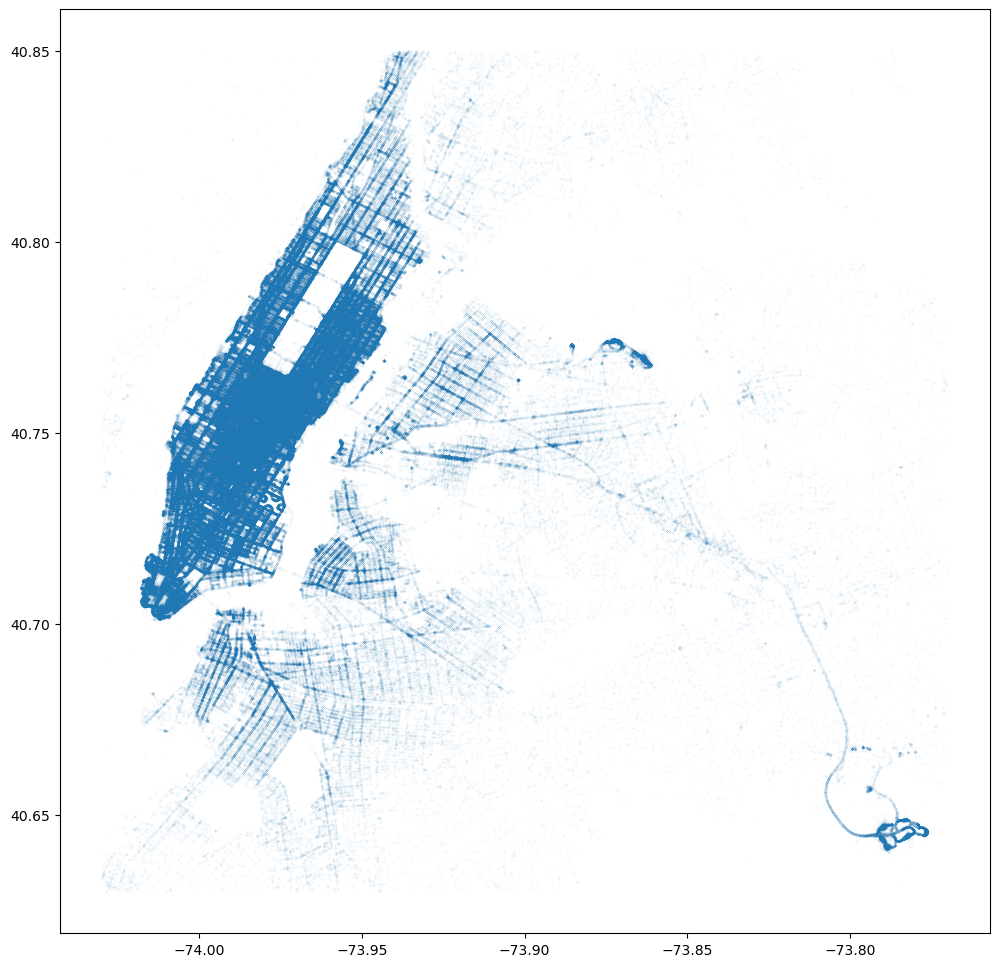

In [9]:
#Where is the concentration area for getting on and off the bus?
longitude = list(df.pickup_longitude) + list(df.dropoff_longitude)
latitude = list(df.pickup_latitude) + list(df.dropoff_latitude)
plt.figure(figsize = (12,12))
plt.plot(longitude,latitude,'.', alpha = 0.8, markersize = 0.05)
plt.show()

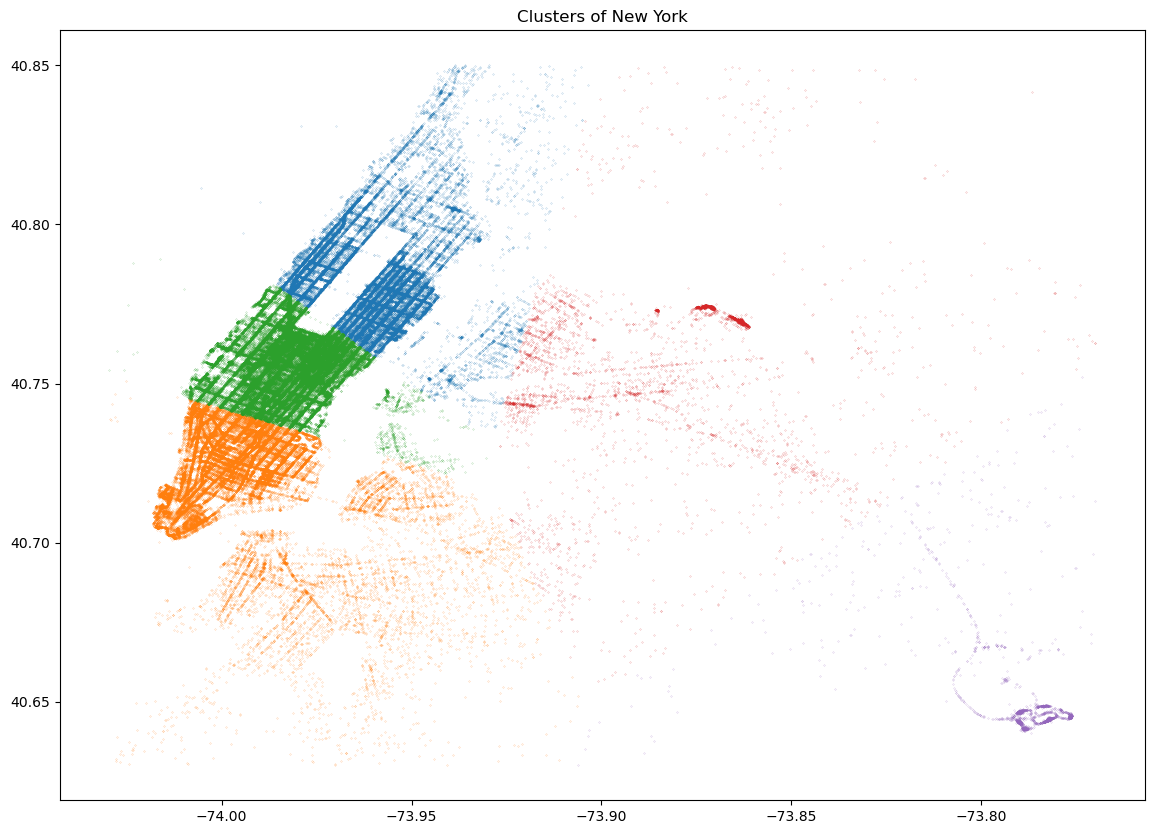

40.64997282388483


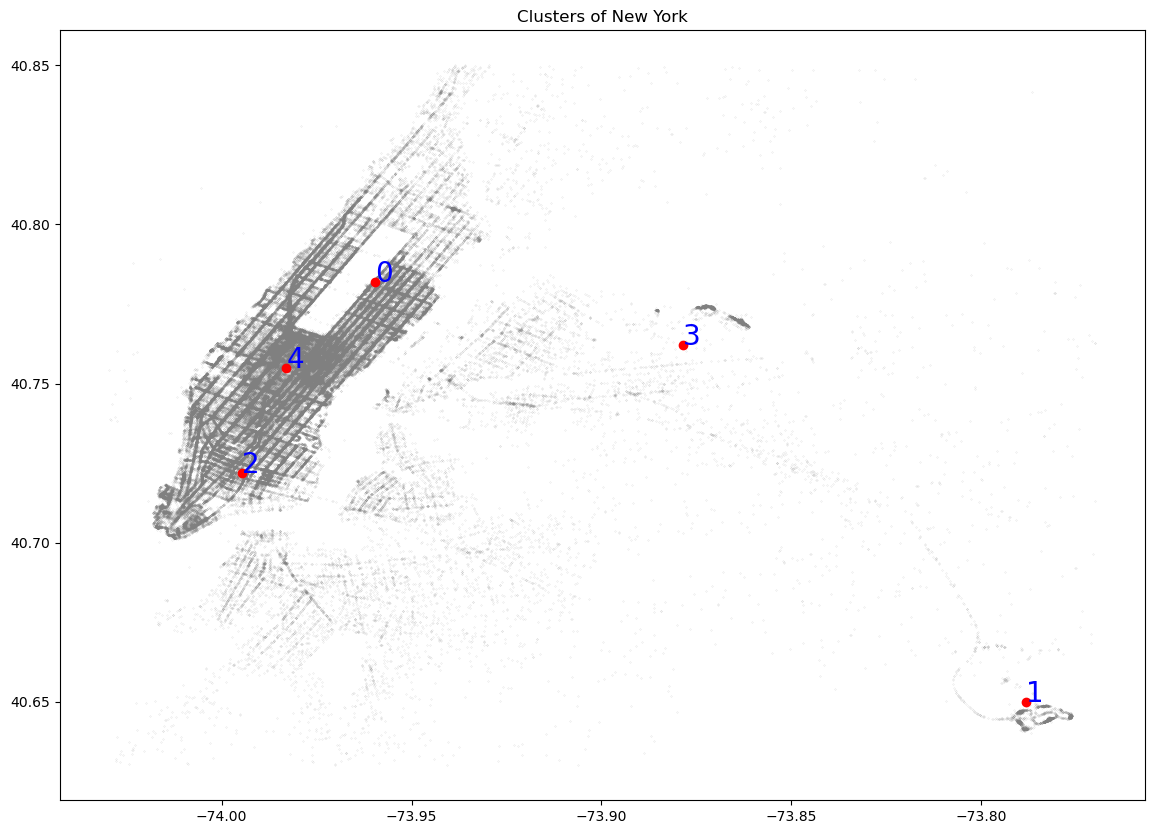

In [11]:
#Clustering based on drop-off and pick-up locations
loc_df=pd.DataFrame()
loc_df['longitude']=longitude
loc_df['latitude']=latitude

kmeans = KMeans(n_clusters=5, random_state=2, n_init = 10).fit(loc_df)

loc_df['label']=kmeans.labels_
loc_df=loc_df.sample(200000)

plt.figure(figsize = (14,10))

for label in loc_df.label.unique():
    plt.plot(loc_df.longitude[loc_df.label == label],loc_df.latitude[loc_df.label == label],'.', alpha = 0.8, markersize = 0.3)

plt.title('Clusters of New York')
plt.show()
print(kmeans.cluster_centers_[label,1])

#Digitally tagging categories
fig,ax=plt.subplots(figsize = (14,10))
for label in loc_df.label.unique():
    ax.plot(loc_df.longitude[loc_df.label == label],loc_df.latitude[loc_df.label == label],'.', alpha = 0.5, markersize = 0.3,color='gray')
    ax.plot(kmeans.cluster_centers_[label,0],kmeans.cluster_centers_[label,1],'o', color = 'r')  #centers指的是什么?
    ax.annotate(label, (kmeans.cluster_centers_[label,0],kmeans.cluster_centers_[label,1]), color = 'b', fontsize = 20)

ax.set_title('Clusters of New York')
plt.show()

In [12]:
df['pickup_cluster'] = kmeans.fit(df[['pickup_longitude','pickup_latitude']])
df['dropoff_cluster'] = kmeans.fit(df[['dropoff_longitude','dropoff_latitude']])
df['pickup_hour'] = df.pickup_datetime.apply(lambda x: parser.parse(x).hour )
print(df.head())
print(loc_df.head())

          id  vendor_id      pickup_datetime     dropoff_datetime  \
0  id2875421          2  2016-03-14 17:24:55  2016-03-14 17:32:30   
1  id2377394          1  2016-06-12 00:43:35  2016-06-12 00:54:38   
2  id3858529          2  2016-01-19 11:35:24  2016-01-19 12:10:48   
3  id3504673          2  2016-04-06 19:32:31  2016-04-06 19:39:40   
4  id2181028          2  2016-03-26 13:30:55  2016-03-26 13:38:10   

   passenger_count  pickup_longitude  pickup_latitude  dropoff_longitude  \
0                1        -73.982155        40.767937         -73.964630   
1                1        -73.980415        40.738564         -73.999481   
2                1        -73.979027        40.763939         -74.005333   
3                1        -74.010040        40.719971         -74.012268   
4                1        -73.973053        40.793209         -73.972923   

   dropoff_latitude store_and_fwd_flag  trip_duration  \
0         40.765602                  N            455   
1         40.7

In [13]:
#Categorize the centroids
clusters=pd.DataFrame()
clusters['x']=kmeans.cluster_centers_[:,0]
clusters['y']=kmeans.cluster_centers_[:,1]
clusters['label']=range(len(clusters))
clusters.x[clusters.label==1]

loc_df=loc_df.sample(5000)
loc_df.head()

,longitude,latitude,label
553498,-73.873657,40.773876,3
365324,-74.005371,40.736652,2
464825,-73.978996,40.755863,4
190175,-73.987991,40.754311,4
2014924,-74.012062,40.713718,2


In [14]:
#Direction of travel analysis based on boarding and alighting data
fig, ax = plt.subplots(1, 1, figsize = (20,20))

def animate(hour):
    ax.clear()
    ax.set_title('Relative Traffic - Hour ' + str(int(hour)) + ':00')    
    plt.figure(figsize = (10,10))
    for label in loc_df.label.unique():
        ax.plot(loc_df.longitude[loc_df.label == label],loc_df.latitude[loc_df.label == label],'.', alpha = 1, markersize = 2, color = 'gray')
        ax.plot(kmeans.cluster_centers_[label,0],kmeans.cluster_centers_[label,1],'o', color = 'r')
    
    for label in clusters.label:
        for dest_label in clusters.label:
            num_of_rides = len(df[(df.pickup_cluster == label) & (df.dropoff_cluster == dest_label) & (df.pickup_hour == hour)])
            dist_x = clusters.x[clusters.label == label].values[0] - clusters.x[clusters.label == dest_label].values[0]
            dist_y = clusters.y[clusters.label == label].values[0] - clusters.y[clusters.label == dest_label].values[0]
            pct = np.true_divide(num_of_rides,len(df[df.pickup_hour == hour]))
            arr = Arrow(clusters.x[clusters.label == label].values, clusters.y[clusters.label == label].values, -dist_x, -dist_y, edgecolor='white', width = pct)
            ax.add_patch(arr)
            arr.set_facecolor('g')
            
ani = animation.FuncAnimation(fig,animate,sorted(df.pickup_hour.unique()), interval = 1000)
plt.close()
ani.save('animation01.gif', writer='pillow', fps=2)

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

In [15]:
#KNN 
neighborhood = {-74.0019368351: 'Chelsea',-73.837549761: 'Queens',-73.7854240738: 'JFK',-73.9810421975:'Midtown-North-West',-73.9862336241: 'East Village',
                -73.971273324:'Midtown-North-East',-73.9866739677: 'Brooklyn-parkslope',-73.8690098118: 'LaGuardia',-73.9890572967:'Midtown',-74.0081765545: 'Downtown'
                ,-73.9213024854: 'Queens-Astoria',-73.9470256923: 'Harlem',-73.9555565018: 'Uppe East Side',
               -73.9453487097: 'Brooklyn-Williamsburgt',-73.9745967889:'Upper West Side'}
print(neighborhood.values())

rides_df = pd.DataFrame(columns = neighborhood.values())
rides_df.head()
rides_df['name'] = neighborhood.values()

np.array(list(neighborhood.keys())).reshape(-1, 1)

neigh = KNeighborsClassifier(n_neighbors=1)
neigh.fit(np.array(list(neighborhood.keys())).reshape(-1, 1), list(neighborhood.values()))
df['pickup_neighborhood'] = neigh.predict(df.pickup_longitude.values.reshape(-1,1)) 
df['dropoff_neighborhood'] = neigh.predict(df.dropoff_longitude.values.reshape(-1,1))

for col in rides_df.columns[:-1]:
    rides_df[col] = rides_df.name.apply(lambda x: len(df[(df.pickup_neighborhood == x) & (df.dropoff_neighborhood == col)]))
    print(rides_df[col])

dict_values(['Chelsea', 'Queens', 'JFK', 'Midtown-North-West', 'East Village', 'Midtown-North-East', 'Brooklyn-parkslope', 'LaGuardia', 'Midtown', 'Downtown', 'Queens-Astoria', 'Harlem', 'Uppe East Side', 'Brooklyn-Williamsburgt', 'Upper West Side'])
0     28526
1        27
2      1887
3     17496
4     10616
5      7069
6      6225
7      2055
8     37829
9     20509
10      200
11      850
12     4591
13      427
14     8586
Name: Chelsea, dtype: int64
0      228
1      375
2     1221
3      416
4      186
5      331
6      116
7      950
8      474
9      187
10     189
11      71
12     254
13     104
14     267
Name: Queens, dtype: int64
0      950
1       93
2     2779
3     2183
4     1168
5     1346
6      439
7      793
8     1833
9      869
10     140
11     281
12     983
13     205
14    1418
Name: JFK, dtype: int64
0     18989
1        55
2      3578
3     30833
4     13532
5     24433
6      8320
7      5189
8     41685
9     10457
10      371
11     2603
12    17252
13  

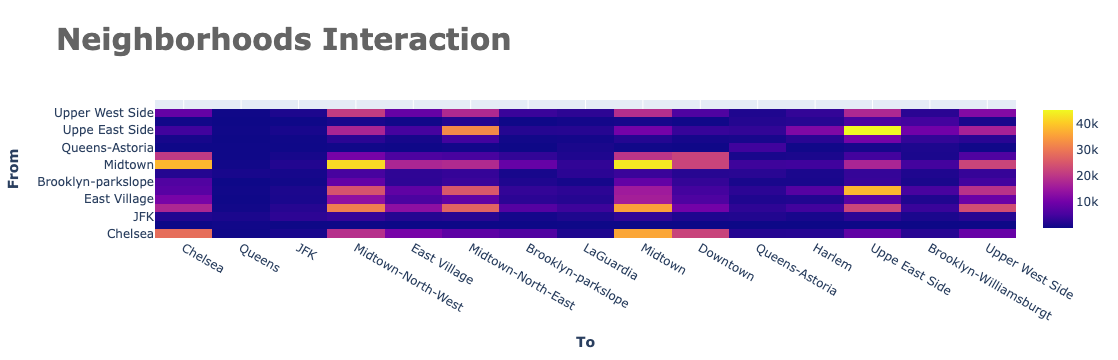

In [16]:
import plotly.offline as py
import plotly.graph_objs as go
py.init_notebook_mode(connected=True)
trace = go.Heatmap(z= rides_df.iloc[:,:].values,#np.array(rides_df.as_matrix()),
                  x = rides_df.columns[:-1],
                  y = rides_df.columns)

layout = dict(
    title = ' <b>Neighborhoods Interaction</b>',
    titlefont = dict(
    size = 30,
    color = ('rgb(100,100,100)')),
    margin = dict(t=100,r=100,b=100,l=150),
        yaxis = dict(
            title = ' <b> From </b>'),
        xaxis = dict(
            title = '<b> To </b>'))

data=[trace]
fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='labelled-heatmap')

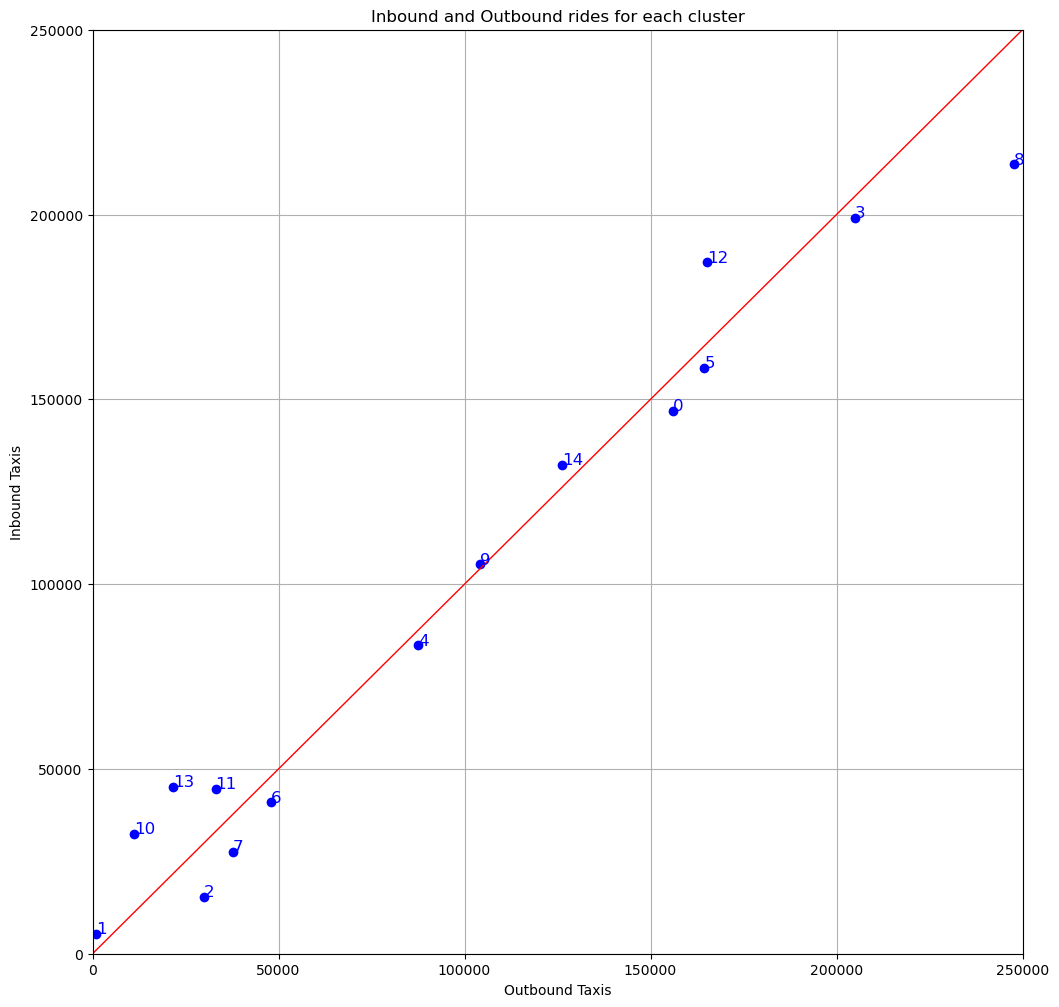

In [17]:
# Incoming and outgoing regional analysis
fig,ax = plt.subplots(figsize = (12,12))
rides_df = rides_df.apply(pd.to_numeric, errors='coerce')
for i in range(len(rides_df)):  
    ax.plot(rides_df.sum(axis=1).iloc[i],rides_df.sum(axis = 0)[i],'o', color = 'b')  
    ax.annotate(rides_df.index.tolist()[i], (rides_df.sum(axis = 1)[i],rides_df.sum(axis = 0)[i]), color = 'b', fontsize = 12)

ax.plot([0,250000],[0,250000], color = 'r', linewidth = 1)
ax.grid('off')
ax.set_xlim([0,250000])
ax.set_ylim([0,250000])
ax.set_xlabel('Outbound Taxis')
ax.set_ylabel('Inbound Taxis')
ax.set_title('Inbound and Outbound rides for each cluster')
plt.show()   

In [18]:
#Data reading and characterization
s = time.time()
train_fr_1 = pd.read_csv('fastest_routes_train_part_1.csv') 
train_fr_2 = pd.read_csv('fastest_routes_train_part_2.csv')
train_df = pd.read_csv('train.csv')

train_fr = pd.concat([train_fr_1, train_fr_2])
train_fr_new = train_fr[['id', 'total_distance', 'total_travel_time', 'number_of_steps']]
train = pd.merge(train_df, train_fr_new, on = 'id', how = 'left')
train_df=train.copy()

end=time.time()
print("Time taken by above cell is {}.".format((end-s)))
print(train_df.head())

train_data = train_df.copy()
print("Number of columns and rows and columns are {} and {} respectively.".format(train_data.shape[1], train_data.shape[0]))
if train_data.id.nunique() == train_data.shape[0]: 
    print("Train ids are unique")
print("Number of Nulls - {}.".format(train_data.isnull().sum().sum()))
print('Most of the ride lengths are：',np.exp(4)/60,np.exp(8)/60)
print('Ride length anomalies are：',np.exp(2)/60,np.exp(12)/60)

Time taken by above cell is 8.231380939483643.
          id  vendor_id      pickup_datetime     dropoff_datetime  \
0  id2875421          2  2016-03-14 17:24:55  2016-03-14 17:32:30   
1  id2377394          1  2016-06-12 00:43:35  2016-06-12 00:54:38   
2  id3858529          2  2016-01-19 11:35:24  2016-01-19 12:10:48   
3  id3504673          2  2016-04-06 19:32:31  2016-04-06 19:39:40   
4  id2181028          2  2016-03-26 13:30:55  2016-03-26 13:38:10   

   passenger_count  pickup_longitude  pickup_latitude  dropoff_longitude  \
0                1        -73.982155        40.767937         -73.964630   
1                1        -73.980415        40.738564         -73.999481   
2                1        -73.979027        40.763939         -74.005333   
3                1        -74.010040        40.719971         -74.012268   
4                1        -73.973053        40.793209         -73.972923   

   dropoff_latitude store_and_fwd_flag  trip_duration  total_distance  \
0       

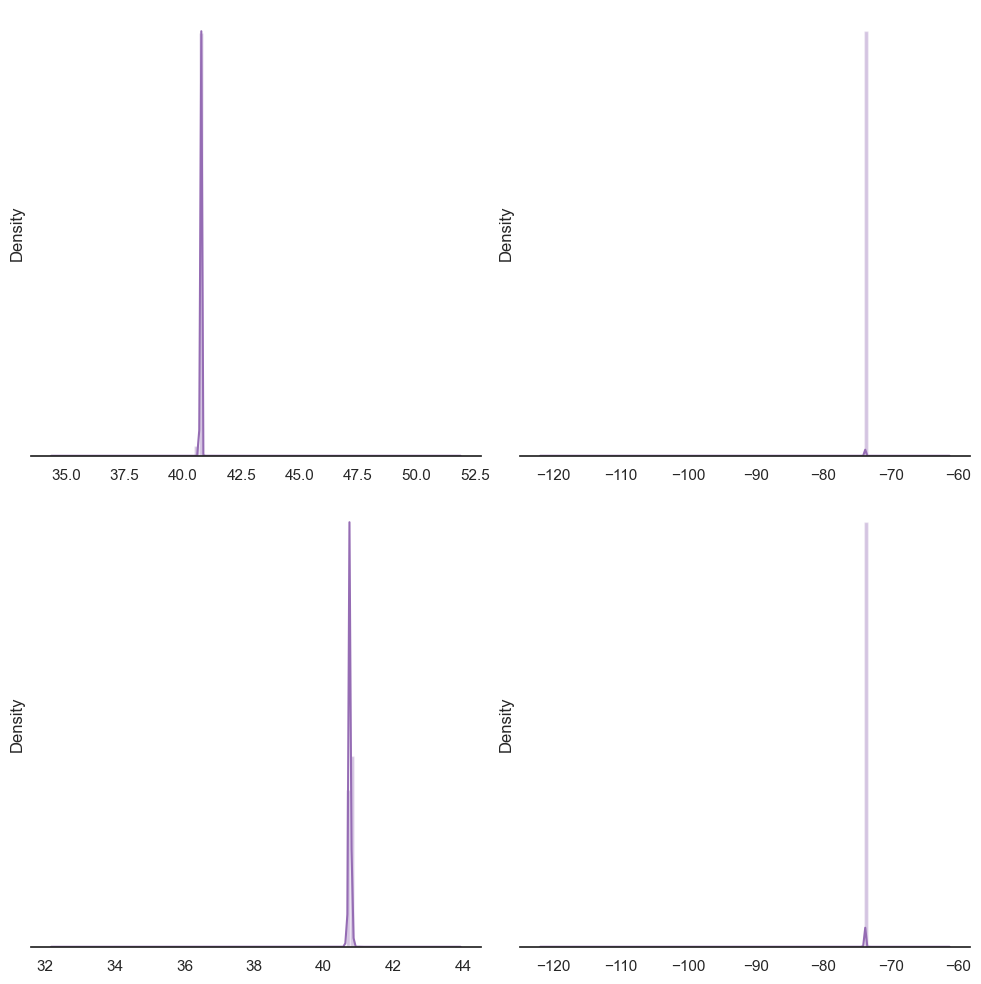

In [20]:
# Location data around latitude and longitude
sns.set(style="white", palette="muted", color_codes=True)
f, axes = plt.subplots(2,2,figsize=(10, 10), sharex=False, sharey = False)
sns.despine(left=True)

sns.distplot(train_df['pickup_latitude'].values, label = 'pickup_latitude',color="m",bins = 100, ax=axes[0,0])
sns.distplot(train_df['pickup_longitude'].values, label = 'pickup_longitude',color="m",bins =100, ax=axes[0,1])
sns.distplot(train_df['dropoff_latitude'].values, label = 'dropoff_latitude',color="m",bins =100, ax=axes[1, 0])
sns.distplot(train_df['dropoff_longitude'].values, label = 'dropoff_longitude',color="m",bins =100, ax=axes[1, 1])

plt.setp(axes, yticks=[])
plt.tight_layout()
plt.show()

1452385 1458644


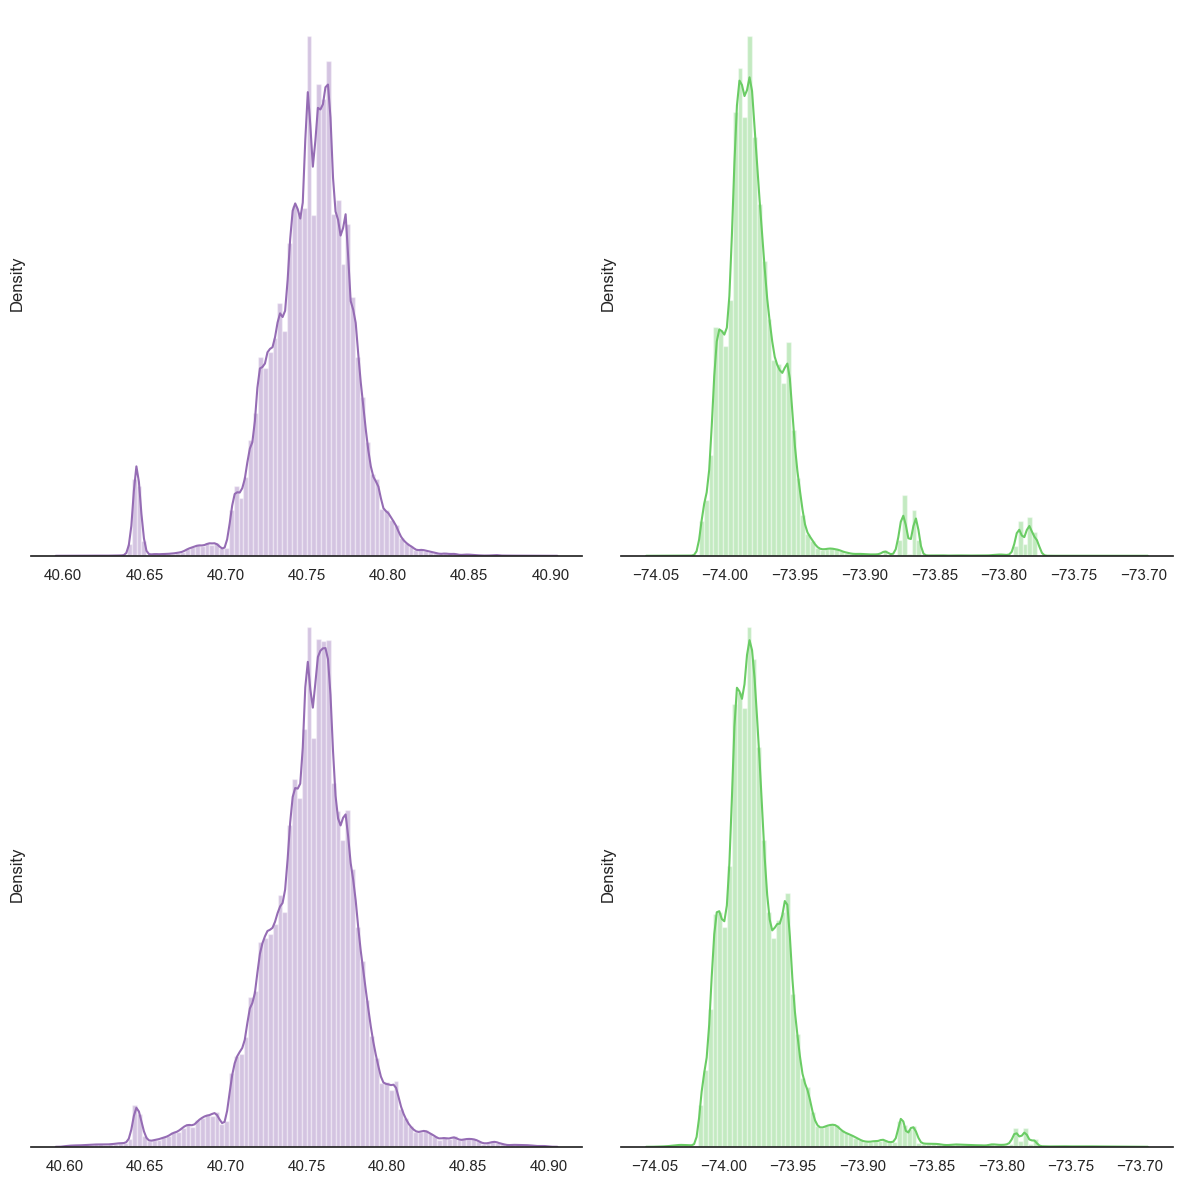

In [21]:
# Filtering on latitude and longitude
df = train_df.loc[(train_df.pickup_latitude > 40.6) & (train_df.pickup_latitude < 40.9)]
df = df.loc[(df.dropoff_latitude>40.6) & (df.dropoff_latitude < 40.9)]
df = df.loc[(df.dropoff_longitude > -74.05) & (df.dropoff_longitude < -73.7)]
df = df.loc[(df.pickup_longitude > -74.05) & (df.pickup_longitude < -73.7)]
train_data_new = df.copy()

sns.set(style="white", palette="muted", color_codes=True)
f, axes = plt.subplots(2,2,figsize=(12, 12), sharex=False, sharey = False)#
sns.despine(left=True)
sns.distplot(train_data_new['pickup_latitude'].values, label = 'pickup_latitude',color="m",bins = 100, ax=axes[0,0])
sns.distplot(train_data_new['pickup_longitude'].values, label = 'pickup_longitude',color="g",bins =100, ax=axes[0,1])
sns.distplot(train_data_new['dropoff_latitude'].values, label = 'dropoff_latitude',color="m",bins =100, ax=axes[1, 0])
sns.distplot(train_data_new['dropoff_longitude'].values, label = 'dropoff_longitude',color="g",bins =100, ax=axes[1, 1])
plt.setp(axes, yticks=[])
plt.tight_layout()
print(df.shape[0], train_df.shape[0])
plt.show()

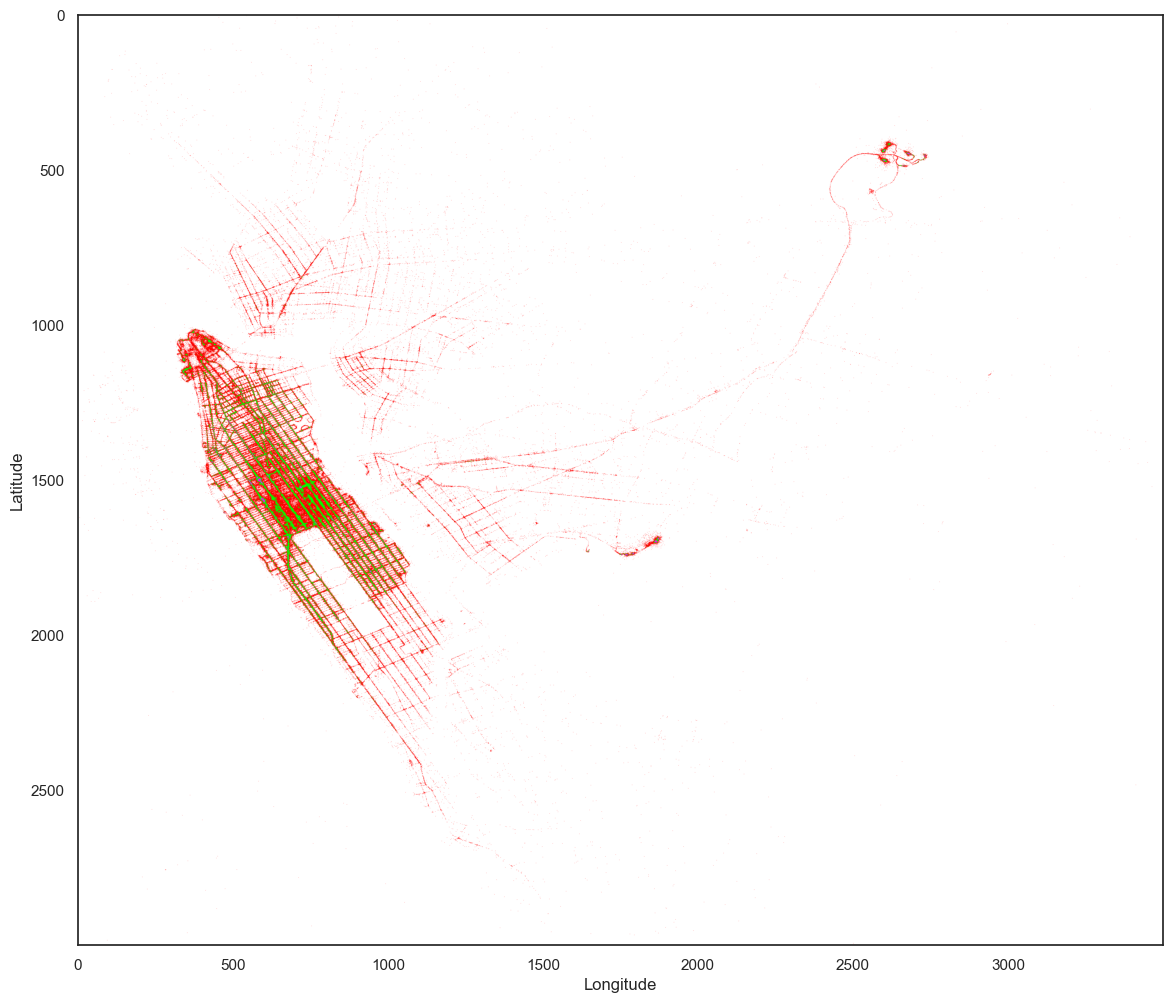

In [22]:
temp = train_data.copy()

rgb = np.zeros((3000, 3500, 3), dtype=np.uint8)
rgb[..., 0] = 255  
rgb[..., 1] = 255
rgb[..., 2] = 255
train_data_new['pick_lat_new'] = list(map(int, (train_data_new['pickup_latitude'] - (40.6000))*10000))
train_data_new['drop_lat_new'] = list(map(int, (train_data_new['dropoff_latitude'] - (40.6000))*10000))
train_data_new['pick_lon_new'] = list(map(int, (train_data_new['pickup_longitude'] - (-74.050))*10000))
train_data_new['drop_lon_new'] = list(map(int,(train_data_new['dropoff_longitude'] - (-74.050))*10000))

summary_plot = pd.DataFrame(train_data_new.groupby(['pick_lat_new', 'pick_lon_new'])['id'].count())
summary_plot.reset_index(inplace = True)

lat_list = summary_plot['pick_lat_new'].unique()

for i in lat_list:
    lon_list = summary_plot.loc[summary_plot['pick_lat_new']==i]['pick_lon_new'].tolist()
    unit = summary_plot.loc[summary_plot['pick_lat_new']==i]['id'].tolist()
    for j in lon_list:
        a = unit[lon_list.index(j)]
        if (a//50) >0:
            rgb[i][j][0] = 255
            rgb[i,j, 1] = 0
            rgb[i,j, 2] = 255
        elif (a//10)>0:
            rgb[i,j, 0] = 0
            rgb[i,j, 1] = 255
            rgb[i,j, 2] = 0
        else:
            rgb[i,j, 0] = 255
            rgb[i,j, 1] = 0
            rgb[i,j, 2] = 0
fig, ax = plt.subplots(nrows=1,ncols=1,figsize=(14,20))
ax.imshow(rgb, cmap = 'hot')
ax.set_xlabel('Longitude')  
ax.set_ylabel('Latitude')  
plt.show()
ax.set_axis_off()

In [23]:
#Feature construction based on actual data 
#Spatial distance calculation

#Utilizing Haversham Distance Calculations
def haversine_(lat1, lng1, lat2, lng2):
    lat1, lng1, lat2, lng2 = map(np.radians, (lat1, lng1, lat2, lng2))
    AVG_EARTH_RADIUS = 6371
    lat = lat2 - lat1
    lng = lng2 - lng1
    d = np.sin(lat * 0.5) ** 2 + np.cos(lat1) * np.cos(lat2) * np.sin(lng * 0.5) ** 2
    h = 2 * AVG_EARTH_RADIUS * np.arcsin(np.sqrt(d))
    return(h)

# Utilizing Manhattan distance calculations
def manhattan_distance_pd(lat1, lng1, lat2, lng2):
    """function to calculate manhatten distance between pick_drop"""
    a = haversine_(lat1, lng1, lat1, lng2)
    b = haversine_(lat1, lng1, lat2, lng1)
    return a + b
import math

# Calculate the bearing between latitude and longitude
def bearing_array(lat1, lng1, lat2, lng2):
    AVG_EARTH_RADIUS = 6371  # in km
    lng_delta_rad = np.radians(lng2 - lng1)
    lat1, lng1, lat2, lng2 = map(np.radians, (lat1, lng1, lat2, lng2))
    y = np.sin(lng_delta_rad) * np.cos(lat2)
    x = np.cos(lat1) * np.sin(lat2) - np.sin(lat1) * np.cos(lat2) * np.cos(lng_delta_rad)
    return np.degrees(np.arctan2(y, x))

# Extract the time dimension
train_data = temp.copy()
train_data['pickup_datetime'] = pd.to_datetime(train_data.pickup_datetime)
train_data.loc[:, 'pick_month'] = train_data['pickup_datetime'].dt.month
train_data.loc[:, 'hour'] = train_data['pickup_datetime'].dt.hour
train_data.loc[:, 'week_of_year'] = train_data['pickup_datetime'].dt.isocalendar().week
train_data.loc[:, 'day_of_year'] = train_data['pickup_datetime'].dt.dayofyear
train_data.loc[:, 'day_of_week'] = train_data['pickup_datetime'].dt.dayofweek

# Extract spatial dimensions
train_data.loc[:,'hvsine_pick_drop'] = haversine_(train_data['pickup_latitude'].values, train_data['pickup_longitude'].values, train_data['dropoff_latitude'].values, train_data['dropoff_longitude'].values)
train_data.loc[:,'manhtn_pick_drop'] = manhattan_distance_pd(train_data['pickup_latitude'].values, train_data['pickup_longitude'].values, train_data['dropoff_latitude'].values, train_data['dropoff_longitude'].values)
train_data.loc[:,'bearing'] = bearing_array(train_data['pickup_latitude'].values, train_data['pickup_longitude'].values, train_data['dropoff_latitude'].values, train_data['dropoff_longitude'].values)
train_data.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,...,total_travel_time,number_of_steps,pick_month,hour,week_of_year,day_of_year,day_of_week,hvsine_pick_drop,manhtn_pick_drop,bearing
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,...,164.9,5.0,3,17,11,74,0,1.498521,1.735433,99.970196
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,...,332.0,6.0,6,0,23,164,6,1.805507,2.430506,-117.153768
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,...,767.6,16.0,1,11,3,19,1,6.385098,8.203575,-159.680165
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,...,235.8,4.0,4,19,14,97,2,1.485498,1.661331,-172.737700
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,...,140.1,5.0,3,13,12,86,5,1.188588,1.199457,179.473585


In [24]:
def color(hour):
    """function for color change in animation"""
    return(10*hour)

def Animation(hour, temp, rgb):
    """Function to generate return a pic of plotings"""
    
    train_data_new = temp.loc[temp['hour'] == hour]
    start = time.time()
    rgb = np.zeros((3000, 3500, 3), dtype=np.uint8)
    rgb[..., 0] = 0
    rgb[..., 1] = 0
    rgb[..., 2] = 0
    train_data_new['pick_lat_new'] = list(map(int, (train_data_new['pickup_latitude'] - (40.6000))*10000))
    train_data_new['drop_lat_new'] = list(map(int, (train_data_new['dropoff_latitude'] - (40.6000))*10000))
    train_data_new['pick_lon_new'] = list(map(int, (train_data_new['pickup_longitude'] - (-74.050))*10000))
    train_data_new['drop_lon_new'] = list(map(int,(train_data_new['dropoff_longitude'] - (-74.050))*10000))

    summary_plot = pd.DataFrame(train_data_new.groupby(['pick_lat_new', 'pick_lon_new'])['id'].count())
    summary_plot.reset_index(inplace = True)

    lat_list = summary_plot['pick_lat_new'].unique()
    
    for i in lat_list:
        #print(i)
        lon_list = summary_plot.loc[summary_plot['pick_lat_new']==i]['pick_lon_new'].tolist()
        unit = summary_plot.loc[summary_plot['pick_lat_new']==i]['id'].tolist()
        for j in lon_list:
            #j = int(j)
            a = unit[lon_list.index(j)]
            #print(a)
            if (a//50) >0:
                rgb[i][j][0] = 255 - color(hour)
                rgb[i,j, 1] = 255 - color(hour)
                rgb[i,j, 2] = 0 + color(hour)
            elif (a//10)>0:
                rgb[i,j, 0] = 0 + color(hour)
                rgb[i,j, 1] = 255 - color(hour)
                rgb[i,j, 2] = 0 + color(hour)
            else:
                rgb[i,j, 0] = 255 - color(hour)
                rgb[i,j, 1] = 0 + color(hour)
                rgb[i,j, 2] = 0 + color(hour)
    fig, ax = plt.subplots(nrows=1,ncols=1,figsize=(14,20))
    ax.imshow(rgb)
    ax.set_axis_off()
    return(rgb)

images_list=[]
train_data_new['pickup_datetime'] = pd.to_datetime(train_data_new.pickup_datetime)
train_data_new.loc[:, 'hour'] = train_data_new['pickup_datetime'].dt.hour

for i in list(range(0, 24)):
    im = Animation(i, train_data_new, rgb.copy())
    images_list.append(im)
    plt.close()

def build_gif(imgs = images_list, show_gif=False, save_gif=True, title=''):
    """function to create a gif of heatmaps"""
    fig, ax = plt.subplots(nrows=1,ncols=1,figsize=(10,10))
    ax.set_axis_off()
    hr_range = list(range(0,24))
    def show_im(pairs):
        ax.clear()
        ax.set_title('Absolute Traffic - Hour ' + str(int(pairs[0])) + ':00')
        ax.imshow(pairs[1])
        ax.set_axis_off()
    pairs = list(zip(hr_range, imgs))
    
    im_ani = animation.FuncAnimation(fig, show_im, pairs,interval=500, repeat_delay=0, blit=False)
    if save_gif:
        im_ani.save('animation2.gif', writer='Pillow')
    return

In [1]:
# Some characterization of the length of relevant passenger time in a week via the vendor_id feature
summary_wdays_avg_duration = pd.DataFrame(train_data.groupby(['vendor_id','day_of_week'])['trip_duration'].mean()) 
summary_wdays_avg_duration.reset_index(inplace = True)

summary_wdays_avg_duration['unit']=1
summary_wdays_avg_duration.head()

sns.set(style="white", palette="muted", color_codes=True)
sns.set_context("poster")

sns.lineplot(x=summary_wdays_avg_duration['day_of_week'],y=summary_wdays_avg_duration['trip_duration'],hue=summary_wdays_avg_duration['vendor_id']) 
sns.despine(bottom = False)

plt.rcParams['figure.figsize']=[14,8]
sns.set(style="whitegrid", palette="pastel", color_codes=True)
sns.set_context("poster")


sns.set(style="ticks")
sns.set_context("poster")
sns.boxplot(x="day_of_week", y="trip_duration", hue="vendor_id", data=train_data, palette="PRGn")
plt.ylim(0, 6000)
plt.legend(loc = 'upper right')
sns.despine(offset=10, trim=True)
print(train_data.trip_duration.max())

summary_hour_duration = pd.DataFrame(train_data.groupby(['day_of_week','hour'])['trip_duration'].mean())
summary_hour_duration.reset_index(inplace = True)
summary_hour_duration['unit']=1
sns.set(style="white", palette="muted", color_codes=False)
sns.set_context("poster")
sns.lineplot(x=summary_hour_duration['hour'],y=summary_hour_duration['trip_duration'],hue=summary_hour_duration['day_of_week'])
sns.despine(bottom = False)

NameError: name 'pd' is not defined

In [83]:
# Clustering in space
def assign_cluster(df, k):
    df_pick = df[['pickup_longitude', 'pickup_latitude']]
    df_drop = df[['dropoff_longitude', 'dropoff_latitude']]
    
    # Fixed initialization centers, note: the number of initialization centers should be the same as k
    init = np.array([
        [ -73.98737616,  40.72981533],
        [-121.93328857,  37.38933945],
        [ -73.78423222,  40.64711269],
        [ -73.9546417 ,  40.77377538],
        [ -66.84140269,  36.64537175],
        [ -73.87040541,  40.77016484],
        [ -73.97316185,  40.75814346],
        [ -73.98861094,  40.7527791 ],
        [ -72.80966949,  51.88108444],
        [ -76.99779701,  38.47370625],
        [ -73.96975298,  40.69089596],
        [ -74.00816622,  40.71414939],
        [ -66.97216034,  44.37194443],
        [ -61.33552933,  37.85105133],
        [ -73.98001393,  40.7783577 ],
        [ -72.00626526,  43.20296402],
        [ -73.07618713,  35.03469086],
        [ -73.95759366,  40.80316361],
        [ -79.20167796,  41.04752096],
        [ -74.00106031,  40.73867723]
    ])
    
    # If k does not match the number of initialized centers, prompt and adjust 
    if k != init.shape[0]:
        print("警告: k 与初始中心数量不一致，自动调整 k 为", init.shape[0])
        k = init.shape[0]
    
    # Clustering of pickup data
    k_means_pick = KMeans(n_clusters=k, init=init, n_init=1)
    k_means_pick.fit(df_pick)
    df['label_pick'] = k_means_pick.labels_
    
     # Rename the column names of the dropoff data to be consistent with the training
    df_drop_renamed = df_drop.rename(columns={
        'dropoff_longitude': 'pickup_longitude',
        'dropoff_latitude': 'pickup_latitude'
    })
    df['label_drop'] = k_means_pick.predict(df_drop_renamed)
    
    return df, k_means_pick

train_cl, k_means = assign_cluster(train_data, 20)
centroid_pickups = pd.DataFrame(k_means.cluster_centers_, columns = ['centroid_pick_long', 'centroid_pick_lat'])
centroid_dropoff = pd.DataFrame(k_means.cluster_centers_, columns = ['centroid_drop_long', 'centroid_drop_lat'])
centroid_pickups['label_pick'] = centroid_pickups.index
centroid_dropoff['label_drop'] = centroid_dropoff.index
train_cl = pd.merge(train_cl, centroid_pickups, how='left', on=['label_pick'])
train_cl = pd.merge(train_cl, centroid_dropoff, how='left', on=['label_drop'])

train_cl.loc[:,'hvsine_pick_cent_p'] = haversine_(train_cl['pickup_latitude'].values, train_cl['pickup_longitude'].values, train_cl['centroid_pick_lat'].values, train_cl['centroid_pick_long'].values)
train_cl.loc[:,'hvsine_drop_cent_d'] = haversine_(train_cl['dropoff_latitude'].values, train_cl['dropoff_longitude'].values, train_cl['centroid_drop_lat'].values, train_cl['centroid_drop_long'].values)
train_cl.loc[:,'hvsine_cent_p_cent_d'] = haversine_(train_cl['centroid_pick_lat'].values, train_cl['centroid_pick_long'].values, train_cl['centroid_drop_lat'].values, train_cl['centroid_drop_long'].values)
train_cl.loc[:,'manhtn_pick_cent_p'] = manhattan_distance_pd(train_cl['pickup_latitude'].values, train_cl['pickup_longitude'].values, train_cl['centroid_pick_lat'].values, train_cl['centroid_pick_long'].values)
train_cl.loc[:,'manhtn_drop_cent_d'] = manhattan_distance_pd(train_cl['dropoff_latitude'].values, train_cl['dropoff_longitude'].values, train_cl['centroid_drop_lat'].values, train_cl['centroid_drop_long'].values)
train_cl.loc[:,'manhtn_cent_p_cent_d'] = manhattan_distance_pd(train_cl['centroid_pick_lat'].values, train_cl['centroid_pick_long'].values, train_cl['centroid_drop_lat'].values, train_cl['centroid_drop_long'].values)
train_cl.loc[:,'bearing_pick_cent_p'] = bearing_array(train_cl['pickup_latitude'].values, train_cl['pickup_longitude'].values, train_cl['centroid_pick_lat'].values, train_cl['centroid_pick_long'].values)
train_cl.loc[:,'bearing_drop_cent_p'] = bearing_array(train_cl['dropoff_latitude'].values, train_cl['dropoff_longitude'].values, train_cl['centroid_drop_lat'].values, train_cl['centroid_drop_long'].values)
train_cl.loc[:,'bearing_cent_p_cent_d'] = bearing_array(train_cl['centroid_pick_lat'].values, train_cl['centroid_pick_long'].values, train_cl['centroid_drop_lat'].values, train_cl['centroid_drop_long'].values)
train_cl['speed_hvsn'] = train_cl.hvsine_pick_drop/train_cl.total_travel_time
train_cl['speed_manhtn'] = train_cl.manhtn_pick_drop/train_cl.total_travel_time

train_cl.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,...,hvsine_drop_cent_d,hvsine_cent_p_cent_d,manhtn_pick_cent_p,manhtn_drop_cent_d,manhtn_cent_p_cent_d,bearing_pick_cent_p,bearing_drop_cent_p,bearing_cent_p_cent_d,speed_hvsn,speed_manhtn
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,...,1.098585,2.319857,1.338601,1.549840,2.822553,8.812218,-138.980503,165.640915,0.009087,0.010524
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,...,0.845448,1.520191,1.573052,0.968702,2.144236,-149.031278,-9.113659,-49.174617,0.005438,0.007321
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,...,0.508922,5.718571,1.135490,0.690697,7.848844,142.642889,-28.669171,-148.907292,0.008318,0.010687
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,...,0.888828,0.000000,0.805089,1.161466,0.000000,166.837718,22.515049,0.000000,0.006300,0.007046
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,...,0.755820,0.000000,2.237846,1.060322,0.000000,-160.438403,-127.746230,0.000000,0.008484,0.008561


In [95]:
def cluster_summary(sum_df):
    summary_avg_time = pd.DataFrame(sum_df.groupby('label_pick')['trip_duration'].mean())
    summary_avg_time.reset_index(inplace = True)

    summary_pref_clus = pd.DataFrame(sum_df.groupby(['label_pick', 'label_drop'])['id'].count())
    summary_pref_clus = summary_pref_clus.reset_index()
    summary_pref_clus = summary_pref_clus.loc[summary_pref_clus.groupby('label_pick')['id'].idxmax()]
    summary =pd.merge(summary_avg_time, summary_pref_clus, how = 'left', on = 'label_pick')
    summary = summary.rename(columns={'trip_duration':'avg_triptime'})
    return summary

# Data visualization on maps
def show_fmaps(train_data, path=1):
    full_data = train_data
    summary_full_data = pd.DataFrame(full_data.groupby('label_pick')['id'].count())
    summary_full_data.reset_index(inplace = True)
    summary_full_data = summary_full_data.loc[summary_full_data['id']>10000]
    map_1 = folium.Map(location=[40.767937, -73.982155], zoom_start=10,tiles='Stamen Toner') 
    new_df = train_data.loc[train_data['label_pick'].isin(summary_full_data.label_pick.tolist())].sample(100)
    new_df.reset_index(inplace = True, drop = True)
    for i in range(new_df.shape[0]): 
        pick_long = new_df.loc[new_df.index ==i]['pickup_longitude'].values[0]
        pick_lat = new_df.loc[new_df.index ==i]['pickup_latitude'].values[0]
        dest_long = new_df.loc[new_df.index ==i]['dropoff_longitude'].values[0]
        dest_lat = new_df.loc[new_df.index ==i]['dropoff_latitude'].values[0]
        folium.Marker([pick_lat, pick_long]).add_to(map_1)
        folium.Marker([dest_lat, dest_long]).add_to(map_1)
    return map_1

def clusters_map(clus_data, full_data, tile = 'OpenStreetMap', sig = 0, zoom = 12, circle = 0, radius_ = 30):
    map_1 = folium.Map(location=[40.767937, -73.982155], zoom_start=zoom,tiles= tile)
    summary_full_data = pd.DataFrame(full_data.groupby('label_pick')['id'].count())
    summary_full_data.reset_index(inplace = True)
    if sig == 1:
        summary_full_data = summary_full_data.loc[summary_full_data['id']>70000]
    sig_cluster = summary_full_data['label_pick'].tolist()
    clus_summary = cluster_summary(full_data)
    for i in sig_cluster:  #转换簇，找到其经纬度
        pick_long = clus_data.loc[clus_data.index ==i]['centroid_pick_long'].values[0]
        pick_lat = clus_data.loc[clus_data.index ==i]['centroid_pick_lat'].values[0]
        clus_no = clus_data.loc[clus_data.index ==i]['label_pick'].values[0]
        most_visited_clus = clus_summary.loc[clus_summary['label_pick']==i]['label_drop'].values[0]
        avg_triptime = clus_summary.loc[clus_summary['label_pick']==i]['avg_triptime'].values[0]
        pop = 'cluster = '+str(clus_no)+' & most visited cluster = ' +str(most_visited_clus) +' & avg triptime from this cluster =' + str(avg_triptime)
        if circle == 1:
            folium.CircleMarker(location=[pick_lat, pick_long], radius=radius_,
                    color='#F08080',
                    fill_color='#3186cc', popup=pop).add_to(map_1)
        folium.Marker([pick_lat, pick_long], popup=pop).add_to(map_1)
    return map_1

osm = show_fmaps(train_data, path=1)
osm.save('taxiclustermap.html')
webbrowser.open('taxiclustermap.html')
clus_map = clusters_map(centroid_pickups, train_cl, sig =0, zoom =10, circle =1, tile = 'Stamen Terrain')
clus_map_sig = clusters_map(centroid_pickups, train_cl, sig =1, circle =1)
map_1 = folium.Map(location=[40.767937, -73.982155], zoom_start=10,tiles='Stamen Toner') 
clus_map_sig

In [97]:
folium.Map(location=[26.08, 119.28], zoom_start=10,tiles='http://webst02.is.autonavi.com/appmaptile?style=6&x={x}&y={y}&z={z}',attr='default') 

In [103]:
# Lets Add PCA features in the model, reference Beluga's PCA
train = train_cl
start = time.time ()
coords = np. vstack ((train[['pickup_latitude', 'pickup_longitude']]. values, 
                      train[['dropoff_latitude','dropoff_longitude']]. values))

pca = PCA (). fit (coords)
train[' pickup_pca0' ] = pca. transform(train[['pickup_latitude', 'pickup_longitude']]) [:, 0]
train [' pickup_pca1'] = pca. transform(train[['pickup_latitude', 'pickup_longitude']]) [:, 1]
train[' dropoff_pca0' ] = pca. transform(train[['dropoff_latitude', 'dropoff_longitude']]) [:, 0]
train[' dropoff_pca1' ] = pca. transform(train[['dropoff_latitude', 'dropoff_longitude']]) [:, 1]

end = time.time ()
print ("Time Taken by above cell is {}.". format (end - start))
train['store_and_fwd_flag_int'] = np.where(train['store_and_fwd_flag']== 'N',0, 1)
train_cl.columns.tolist()

Time Taken by above cell is 0.18538808822631836.


['id',
 'vendor_id',
 'pickup_datetime',
 'dropoff_datetime',
 'passenger_count',
 'pickup_longitude',
 'pickup_latitude',
 'dropoff_longitude',
 'dropoff_latitude',
 'store_and_fwd_flag',
 'trip_duration',
 'total_distance',
 'total_travel_time',
 'number_of_steps',
 'pick_month',
 'hour',
 'week_of_year',
 'day_of_year',
 'day_of_week',
 'hvsine_pick_drop',
 'manhtn_pick_drop',
 'bearing',
 'label_pick',
 'label_drop',
 'centroid_pick_long',
 'centroid_pick_lat',
 'centroid_drop_long',
 'centroid_drop_lat',
 'hvsine_pick_cent_p',
 'hvsine_drop_cent_d',
 'hvsine_cent_p_cent_d',
 'manhtn_pick_cent_p',
 'manhtn_drop_cent_d',
 'manhtn_cent_p_cent_d',
 'bearing_pick_cent_p',
 'bearing_drop_cent_p',
 'bearing_cent_p_cent_d',
 'speed_hvsn',
 'speed_manhtn',
 ' pickup_pca0',
 ' pickup_pca1',
 ' dropoff_pca0',
 ' dropoff_pca1',
 'store_and_fwd_flag_int']

In [105]:
train_cl.to_csv('train_cl.csv', index=False)